## Mosaic Unraveler: A tool for visualizing and analyzing mosaics of images
### Problem Statement: 
Given a mosaic of images, let $S$ be the set of shapes (circle, square, and triangle). Determine a function $f: I \rightarrow N$, where $I$ is the input mosaic image, such that $f(I) = (n_c, n_s, n_t)$, where $n_c$, $n_s$, and $n_t$ are the number of circles, squares, and triangles, respectively, identified and counted in $I$ using Canny edge detection and Hough transform algorithms.


In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from typing import List,Tuple

## Approach:




### Applying Gaussian smooth 

First, we want to get rid of these unwanted noice in an image since it can be quite hard for hough transform do the work without clean edges. 

#### Gaussian Blur 
The Gaussian filter is defined as: 
$G(x, y) = \frac{1}{2 \pi \sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$ 

where $\sigma$ is the standard deviation of the Gaussian distribution. Here $(x, y)$ is the coordinate of the pixel in the image.

The reason we do this is because we want to get rid of the unwanted noise in the image since noise can create fake edges and make it hard for hough transform to do the work.

In this following code, the filter works by assinging a weight to each pixel in the image based on its distance from the center of the filter. The weight decrease as the distance from the center increases, this mean that pixel closer to center have a larger influence on the output pixel than pixel farther away from the center.


In [6]:

# Gaussian filter
def gaussian_filter(img: np.ndarray, kernel_size: int = 5, sigma: float = 1.4) -> np.ndarray:
    """Apply a Gaussian filter to an image.
    Args:
        img (np.ndarray): The image to be filtered.
        kernel_size (int, optional): The size of the kernel. Defaults to 5.
        sigma (float, optional): The standard deviation of the Gaussian function. Defaults to 1.4.
    Returns:
        np.ndarray: The filtered image.
    """
    # G_σ = 1/2πσ^2 * e^(-x^2 + y^2 / 2σ^2) Gaussian function for kernel elements
    kernel = np.zeros((kernel_size, kernel_size)) 
    center = kernel_size // 2
    # Calculate the kernel
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - center
            y = j - center
            kernel[i, j] = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) # Gaussian function
    kernel /= (2 * np.pi * sigma ** 2)
    kernel /= kernel.sum()

    # Convolve the image with the Gaussian kernel
    img_filtered = np.zeros(img.shape)
    img_padded = np.zeros((img.shape[0] + kernel_size - 1, img.shape[1] + kernel_size - 1))
    img_padded[center: -center, center: -center] = img
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            img_filtered[y, x] = (kernel * img_padded[y: y + kernel_size, x: x + kernel_size]).sum()
    return img_filtered

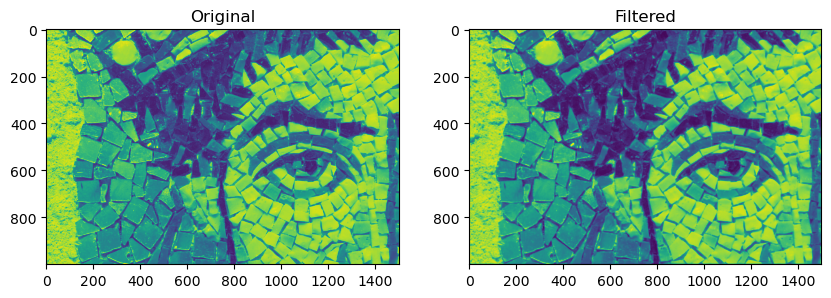

In [9]:
# Let's compare the result of the Gaussian filter with the original image
img_sample_mosaic_01 = plt.imread('mosaic_art/sample_1.jpeg')
img_sample_mosaic_01 = img_sample_mosaic_01[:, :, 0]
img_sample_mosaic_01_filtered = gaussian_filter(img_sample_mosaic_01)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_sample_mosaic_01)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(img_sample_mosaic_01_filtered)
plt.title('Filtered')
plt.show()


Hence we can see that the image is much smoother than the original image.

### Convolving the image
Convolve function are implemented in this case to apply to different filter kernels. Such that Given 2D Image $I with dimension $M$ x $N$ and 2D kernel $K$ with dimension $m$ x $n$, the convolution of $I$ and $K$ is defined as:
$$ (I * K)(x, y) = \sum_{i=0}^{m-1} \sum_{j=0}^{n-1} I(x - i, y - j) K(i, j) $$

Simply work by sliding the filter kernel over the image and for each position, multiply the kernel with the corresponding part of the image and sum the result.




In [11]:
# Canny edge detection implementation

def convolve2d(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """Convolve a 2D image with a 2D kernel.
    Args:
        image (np.ndarray): The image to be convolved.
        kernel (np.ndarray): The kernel to be convolved.
    Returns:
        np.ndarray: The convolved image.
    """
    # Flip the kernel
    kernel = np.flipud(np.fliplr(kernel))
    # Calculate the output image size
    output = np.zeros_like(image)
    # Add zero padding to the input image
    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2))
    image_padded[1: -1, 1: -1] = image
    # Convolve the image with the kernel
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            output[y, x] = (kernel * image_padded[y: y + 3, x: x + 3]).sum()
    return output
    

#### Sobel Filter
The sobel filter is one of the edge detection operator used to compute the gradident magnitude and orientation of images. The result show how abruptly or smoothly the image changes the each pixel therefore, it can be used to detect the edges of the image. Here defined as following 


$$G_x(x, y) = (I * K_x)(x, y) = \sum_{i=0}^{2} \sum_{j=0}^{2} I(x - i, y - j) K_x(i, j)$$

Where `I` is the input image The sobel kernel consisted of two kernel, `K_x` for detecting horizontal edges and `K_y` vertical edges is defined as:
$$K_x = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}$$

$$K_y = \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}$$

These kernels are convolved with the input image to obtain the gradient magnitude and orientation of the image.

Below is the result of the sobel filter applied to the image. Where convolving the image with `K_x` and `K_y` gives the horizontal and vertical edges of the image respectively. Since we already implemented the convolve function, we can simply call the function to apply the sobel filter to the image.

Next, we then compute the gradient magnitude and orientation of the image using the following formula:

`G = np.sqrt(Ix ** 2 + Iy ** 2)`

`theta = np.arctan2(Iy, Ix)`

Where `G` is the gradient magnitude and `theta` is the gradient orientation.

By using arctan, we can get the angle of the edge at each pixel location. 


In [17]:
def sobel_filter(image) -> Tuple[np.ndarray, np.ndarray]:
    # Define the Sobel kernels
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Convolve the kernels with the image
    Ix = convolve2d(image, kernel_x)
    Iy = convolve2d(image, kernel_y)

    # Calculate the gradient magnitude
    G = np.sqrt(Ix ** 2 + Iy ** 2)
    G /= G.max()

    # Calculate the gradient direction
    theta = np.arctan2(Iy, Ix)
    return G, theta



### visualizing the edge image below we can see the edges of the image, therefore it look much cleaner and better for hough transform to do the work.

In [ ]:
img_sample_mosaic_01_filtered = gaussian_filter(img_sample_mosaic_01)
G, theta = sobel_filter(img_sample_mosaic_01_filtered)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_sample_mosaic_01_filtered, cmap='gray')
plt.title('Filtered')
plt.subplot(1, 2, 2)
plt.imshow(G, cmap='gray')
plt.title('Sobel filter')
plt.show()


#### Non max supression

We then apply non-maximum suppression to the gradient magnitude matrix `G_m` to get rid of the unwanted edges detected by the previous gradient magnitude matrix. 

Given a gradient magnitude matrix `G_m` and a gradient orientation matrix `G_o`, the non-maximum suppression step start by 

1. Calculate the orientation angle in degrees and normalize it to the range[0,180]
$$\theta_{i, j} = (\arctan(O_{i, j}) \times \frac{180}{\pi}) \mod 180$$
2. We then determine two neighboring pixels in the direction of the gradient orientation.
$$(i_q, j_q), (i_r, j_r) =
\begin{cases}
  ((i, j+1), (i, j-1)) & \text{if } 0 \le \theta_{i, j} < 22.5 \text{ or } 157.5 \le \theta_{i, j} \le 180 \\
  ((i+1, j-1), (i-1, j+1)) & \text{if } 22.5 \le \theta_{i, j} < 67.5 \\
  ((i+1, j), (i-1, j)) & \text{if } 67.5 \le \theta_{i, j} < 112.5 \\
  ((i-1, j-1), (i+1, j+1)) & \text{if } 112.5 \le \theta_{i, j} < 157.5
\end{cases}
$$
3. We then check if pixel `(i, j)` is local maximum along the gradient function and set the corresponding value in thinned image `S`
$$S_{i, j} =
\begin{cases}
  G_{i, j} & \text{if } G_{i, j} \ge G_{i_q, j_q} \text{ and } G_{i, j} \ge G_{i_r, j_r} \\
  0 & \text{otherwise}
\end{cases}
$$

The result is a thinned image `S` with the same dimensions as the input image `I`.


In [18]:
def non_max_supression (gradient_magnitude, gradient_orientation) -> np.ndarray:
    supressed = np.zeros(gradient_magnitude.shape)
    orientation_degrees = np.degrees(gradient_orientation) % 180

    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            q = 255
            r = 255

            # Find the neighbouring pixels in the direction of the gradient
            if (0 <= orientation_degrees[i, j] < 22.5) or (157.5 <= orientation_degrees[i, j] <= 180):
                q = gradient_magnitude[i, j + 1]
                r = gradient_magnitude[i, j - 1]
            elif 22.5 <= orientation_degrees[i, j] < 67.5:
                q = gradient_magnitude[i + 1, j - 1]
                r = gradient_magnitude[i - 1, j + 1]
            elif 67.5 <= orientation_degrees[i, j] < 112.5:
                q = gradient_magnitude[i + 1, j]
                r = gradient_magnitude[i - 1, j]
            elif 112.5 <= orientation_degrees[i, j] < 157.5:
                q = gradient_magnitude[i - 1, j - 1]
                r = gradient_magnitude[i + 1, j + 1]

            # If the current pixel is a local maximum, keep it
            if gradient_magnitude[i, j] >= q and gradient_magnitude[i, j] >= r:
                supressed[i, j] = gradient_magnitude[i, j]
            else:
                supressed[i, j] = 0

    return supressed

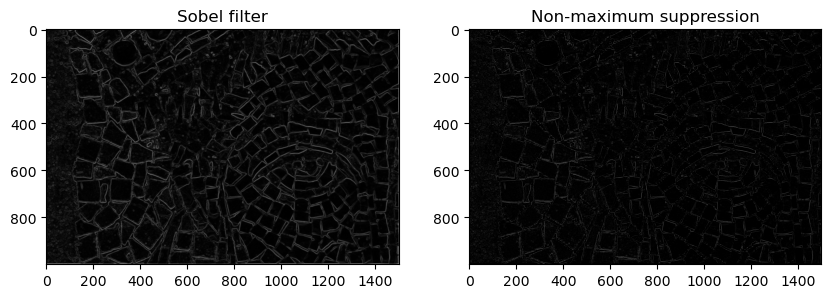

In [19]:
# Test the non-maximum suppression

img_sample_mosaic_01_filtered = gaussian_filter(img_sample_mosaic_01)
G, theta = sobel_filter(img_sample_mosaic_01_filtered)
G_supressed = non_max_supression(G, theta)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(G, cmap='gray')
plt.title('Sobel filter')
plt.subplot(1, 2, 2)
plt.imshow(G_supressed, cmap='gray')
plt.title('Non-maximum suppression')
plt.show()


#### Putting thing together 
We then put all the steps together to implement the final canny edge detection algorithm. In addition to Gaussian, Sobel and non-maximum suppression, we also need to implement the hysteresis thresholding step to get the final edge image. 

Consider idea that weak edges that are connected to strong edges are likely be real edges. Therefore, we can use this idea to get the final edge image such that  The final_edges matrix is initialized with zeros and has the same shape as G_supressed. The code iterates over each pixel in the weak_edges matrix (excluding the border pixels). If a weak edge pixel is found `(weak_edges[i, j] == 1)`, it checks if any neighboring pixels are strong edges `(np.any(strong_edges[i - 1: i + 2, j - 1: j + 2] == 1))`. If there is at least one strong edge neighbor, the weak edge pixel is considered part of the actual edge and set to `1` in the final_edges matrix.

Finally, the final_edges matrix, which contains the refined edges after double thresholding and hysteresis, is returned.


In [20]:
def canny_edge_detection(image: np.ndarray, low_threshold: float, high_threshold: float) -> np.ndarray:
    # Apply Gaussian filter
    image = gaussian_filter(image)
    # Apply Sobel filter
    G, theta = sobel_filter(image)
    # Apply non-maximum suppression
    G_supressed = non_max_supression(G, theta)
    # Apply double threshold
    strong_edges = np.zeros(G_supressed.shape)
    weak_edges = np.zeros(G_supressed.shape)
    strong_edges[G_supressed >= high_threshold] = 1
    weak_edges[G_supressed >= low_threshold] = 1
    # Apply hysteresis
    final_edges = np.zeros(G_supressed.shape)
    for i in range(1, G_supressed.shape[0] - 1):
        for j in range(1, G_supressed.shape[1] - 1):
            if weak_edges[i, j] == 1:
                if np.any(strong_edges[i - 1: i + 2, j - 1: j + 2] == 1):
                    final_edges[i, j] = 1
    return final_edges


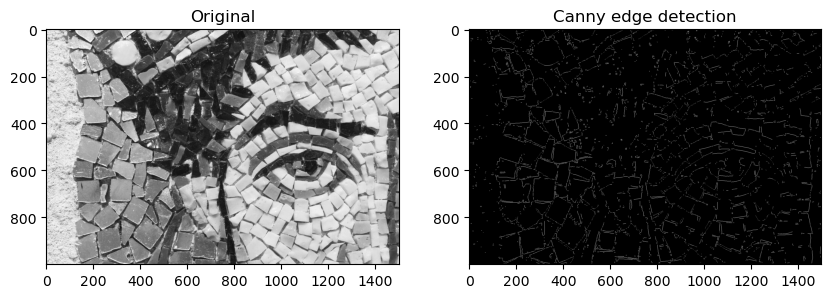

In [21]:
# Test the Canny edge detection

img_sample_mosaic_01_edges = canny_edge_detection(img_sample_mosaic_01, 0.1, 0.2)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_sample_mosaic_01, cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(img_sample_mosaic_01_edges, cmap='gray')
plt.title('Canny edge detection')
plt.show()

## Hough Transform 


In [23]:
def hough_transform(image: np.ndarray, low_threshold: float, high_threshold: float, rho_resolution: float, theta_resolution: float, threshold: int) -> List[Tuple[float,float]]:
    # Apply Canny edge detection
    edges = canny_edge_detection(image, low_threshold, high_threshold)

    lines = cv2.HoughLines(edges, rho_resolution, theta_resolution, threshold)
    return lines

In [22]:
def detect_squares(image: np.ndarray, low_threshold: float, high_threshold: float, rho_resolution: float, theta_resolution: float, threshold: int, min_edge_length: float, max_edge_length: float, angle_tolerance: float) -> int:
    lines = hough_transform(image, low_threshold, high_threshold, rho_resolution, theta_resolution, threshold)
    
    if lines is None:
        return 0

    # Group lines by their angles
    angle_groups = {}
    for line in lines:
        rho, theta = line[0]
        angle = np.rad2deg(theta)
        found_group = False
        for key_angle in angle_groups:
            if abs(angle - key_angle) < angle_tolerance:
                angle_groups[key_angle].append((rho, theta))
                found_group = True
                break

        if not found_group:
            angle_groups[angle] = [(rho, theta)]

    # Check for potential square corners
    square_count = 0
    for angle1, lines1 in angle_groups.items():
        for angle2, lines2 in angle_groups.items():
            if abs(angle1 - angle2) < 90 - angle_tolerance or abs(angle1 - angle2) > 90 + angle_tolerance:
                continue

            for rho1, theta1 in lines1:
                for rho2, theta2 in lines2:
                    # Check if the intersection of two lines is a square corner
                    A = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
                    b = np.array([rho1, rho2])
                    try:
                        x, y = np.linalg.solve(A, b)
                    except np.linalg.LinAlgError:
                        continue

                    # Check if the corner is inside the image
                    if not (0 <= x < image.shape[1] and 0 <= y < image.shape[0]):
                        continue

                    square_side_count = 0
                    for dx, dy in [(1, 1), (1, -1), (-1, 1), (-1, -1)]:
                        line1_found = False
                        line2_found = False
                        for rho, theta in lines:
                            distance = abs((x + dx * min_edge_length) * np.cos(theta) + (y + dy * min_edge_length) * np.sin(theta) - rho)
                            if distance < rho_resolution:
                                if not line1_found:
                                    line1_found = True
                                elif not line2_found:
                                    line2_found = True
                                if line1_found and line2_found:
                                    square_side_count += 1
                                    break

                    if square_side_count == 4:
                        square_count += 1

    return square_count